In [1]:
import copy

from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import torchvision
import torchvision.datasets

In [2]:
# Switch GPU availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Translational equivariance and invariance in neural networks

## Setup datasets

In [3]:
# Define dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]))
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]))

# Define data loading
train_loader =  torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=1)
test_loader =  torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=1)

## Define model

In [4]:
kernel_size = 5
padding = int(np.floor(kernel_size / 2))
channels = 64


class _GlobalMaxPoolNd(nn.Module):
    def __init__(self, n_dims):
        self.n_dims = n_dims
        super().__init__()

    def forward(self, x):
        """Max pool over the right-most `self.n_dims` dimensions and remove the resulting identity dimensions"""
        return F.max_pool2d(x, kernel_size=x.shape[-self.n_dims:]).view(x.shape[:self.n_dims])
    
    def __repr__(self):
        return f'GlobalMaxPool{self.n_dims}d'


class GlobalMaxPool2d(_GlobalMaxPoolNd):
    """Module that applies max pooling globally by having a kernel of the same size as the input
    
    Inputs:
        x (torch.Tensor): Tensor of shape [B, Cin, H, W]
        
    Outputs:
        torch.Tensor: Tensor of shape [B, Cin] where max pooling was applied over H and W
    """
    def __init__(self):
        super().__init__(n_dims=2)


# Define model
class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear_1 = nn.Linear(28*28, 64)
        self.linear_2 = nn.Linear(64, 32)
        self.linear_3 = nn.Linear(32, 10)

        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)
        
    def layer1(self, x):
        x = x.view(-1, 28*28)
        x = self.linear_1(x)
        x = self.relu1(x)
        return x
    
    def layer2(self, x):
        x = x.view(-1, 28*28)
        x = self.linear_1(x)
        x = self.relu1(x)
        x = self.linear_2(x)
        x = self.relu2(x)
        return x

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.linear_1(x)
        x = self.relu1(x)
        x = self.linear_2(x)
        x = self.relu2(x)
        x = self.linear_3(x)
        return self.softmax(x)


class GlobalPoolCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=channels, kernel_size=kernel_size, padding=padding)
        self.max_pool = GlobalMaxPool2d()
        self.linear1 = nn.Linear(channels, 10)

        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)
    
    def max_pool_layer(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.max_pool(x)
        return x

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.max_pool(x)
        x = self.linear1(x)
        return self.softmax(x)


class LocalPoolCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=channels, kernel_size=kernel_size, padding=padding)
        self.max_pool = nn.MaxPool2d(kernel_size=kernel_size, padding=padding, stride=2)
        
        self.max_pool_out = 28 / 2
        self.linear1_in = int(channels * 28/2 * 28/2)
        
        self.linear1 = nn.Linear(self.linear1_in, 10)

        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)
    
    def max_pool_layer(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.max_pool(x)
        return x

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.max_pool(x)
        x = x.view(-1, self.linear1_in)
        x = self.linear1(x)
        return self.softmax(x)
    

# Test the model
x, y = train_dataset[0]

x = x.view(1, 1, 28, 28)

model_mlp = MLP()
yhat = model_mlp(x)
print(x.shape, yhat, y)

model_gcnn = GlobalPoolCNN()
yhat = model_gcnn(x)
print(x.shape, yhat, y)

model_lcnn = LocalPoolCNN()
yhat = model_lcnn(x)
print(x.shape, yhat, y)

torch.Size([1, 1, 28, 28]) tensor([[0.0919, 0.0873, 0.1174, 0.1063, 0.0944, 0.1134, 0.0984, 0.1049, 0.0865,
         0.0995]], grad_fn=<SoftmaxBackward>) 5
torch.Size([1, 1, 28, 28]) tensor([[0.1291, 0.1070, 0.1003, 0.1002, 0.1190, 0.1042, 0.0599, 0.0985, 0.0696,
         0.1122]], grad_fn=<SoftmaxBackward>) 5
torch.Size([1, 1, 28, 28]) tensor([[0.0986, 0.1141, 0.0881, 0.1176, 0.1108, 0.1023, 0.0950, 0.0739, 0.1071,
         0.0925]], grad_fn=<SoftmaxBackward>) 5


### Outline

We will evaluate the translation equivariance and invariance of three different models. 

1. A CNN using a global max-pooling layer to remove spatial information from the input to the final linear classification layer.
2. A CNN using a local max-pooling layer which does not remove spatial information.
3. A vanilla MLP which is fully connected from the input to the output.

We will do the evaluation by computing the outputs and gradient of the output w.r.t. the convolutional kernel (or weight matrix) of the first layer of each model. We will compute the outputs at three points through the models

1. Just after the convolution (or the first linear layer for the MLP)
2. Just after the max pooling operation (or the sercond linear layer for the MLP)
3. Just after the softmax (final output)

By inspecting the outputs themselves, we can evaluate the presence of equivariance or invariance. 

By evaluating the gradients of the output wr.t. the first convolutional kernel we can observe that when the network is translationally equivariant up until the layer used for forward propagation, the gradient of the kernel is the same regardless of translations of the input.


To get some non-random kernels, we start by training the model for a bit. This will allow the kernels to become useful. This is not strictly necessary, but brings the example closer to reality.

One very important thing that happens when we train the network for a bit is that it, regardless of design, begins to learn translation invariance. This is the case even for the MLP. This makes sense since the network will want to predict class 6 for the number 6 regardless of where it is. However, incorporating this invariance by design yields higher statistical effiency of our training samples.

# Convolutional model with global pooling

## Train

In [5]:
# Define model, optimizer and loss
model = GlobalPoolCNN()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

In [6]:
model.to(device)
criterion.to(device)

CrossEntropyLoss()

In [7]:
# Training loop
n_epochs = 10

for epoch in range(n_epochs):
    train_loss = []
    test_loss = []
    for x, y in tqdm(train_loader):
        optimizer.zero_grad()

        x = x.to(device)
        y = y.to(device)

        yhat = model(x)  # Forward pass
        loss = criterion(yhat, y)  # Compute loss

        loss.backward()  # Backward pass
        optimizer.step()  # Update parameters

        train_loss.append(loss.item())

    print(f'Epoch {epoch:3d} | Train loss {np.mean(train_loss):.2f}', end='')

    for x, y in test_loader:
        optimizer.zero_grad()

        x = x.to(device)
        y = y.to(device)

        yhat = model(x)
        loss = criterion(yhat, y)

        test_loss.append(loss.item())

    print(f' | Test loss {np.mean(test_loss):.2f}', end='\n')

100%|██████████| 1875/1875 [00:11<00:00, 164.65it/s]

Epoch   0 | Train loss 2.20


  0%|          | 0/1875 [00:00<?, ?it/s]

 | Test loss 2.08


100%|██████████| 1875/1875 [00:10<00:00, 170.50it/s]

Epoch   1 | Train loss 2.00


  0%|          | 0/1875 [00:00<?, ?it/s]

 | Test loss 1.93


100%|██████████| 1875/1875 [00:11<00:00, 168.74it/s]

Epoch   2 | Train loss 1.89


  0%|          | 0/1875 [00:00<?, ?it/s]

 | Test loss 1.86


100%|██████████| 1875/1875 [00:10<00:00, 174.84it/s]

Epoch   3 | Train loss 1.85


  0%|          | 0/1875 [00:00<?, ?it/s]

 | Test loss 1.84


100%|██████████| 1875/1875 [00:10<00:00, 175.07it/s]

Epoch   4 | Train loss 1.82


  0%|          | 0/1875 [00:00<?, ?it/s]

 | Test loss 1.79


100%|██████████| 1875/1875 [00:11<00:00, 165.60it/s]

Epoch   5 | Train loss 1.76


  0%|          | 0/1875 [00:00<?, ?it/s]

 | Test loss 1.71


100%|██████████| 1875/1875 [00:11<00:00, 163.79it/s]

Epoch   6 | Train loss 1.69


  0%|          | 0/1875 [00:00<?, ?it/s]

 | Test loss 1.68


100%|██████████| 1875/1875 [00:11<00:00, 162.74it/s]

Epoch   7 | Train loss 1.67


  0%|          | 0/1875 [00:00<?, ?it/s]

 | Test loss 1.66


100%|██████████| 1875/1875 [00:11<00:00, 166.15it/s]

Epoch   8 | Train loss 1.66


  0%|          | 0/1875 [00:00<?, ?it/s]

 | Test loss 1.65


100%|██████████| 1875/1875 [00:10<00:00, 172.06it/s]

Epoch   9 | Train loss 1.64

 | Test loss 1.62


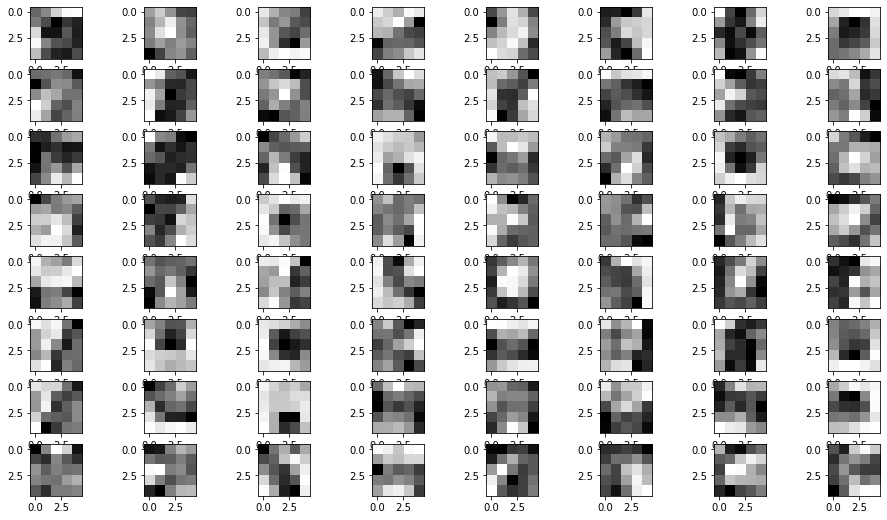

In [8]:
height = int(np.ceil(np.sqrt(channels)))
width = int(np.ceil(np.sqrt(channels)))

fig, axes = plt.subplots(height, width, figsize=(16, 9))
axes = [ax for a in axes for ax in a]

kernels = copy.deepcopy(model.conv1.weight)
kernels = kernels.cpu().detach()
for i, kernel in enumerate(kernels):
    axes[i].imshow(kernel.view(kernel_size, kernel_size), cmap='Greys')

## Check invariance
We will now check the invariance of the CNN by calculating the gradient of the mean activation with respect to the kernels. 

We will pass through an image of a square box and the same image with the box translated. This is the only difference of the input images. The sum of pixel activations in the images are the same. 

Additionally and importantly, the square box is located (in both cases) far enough inside the image that the kernel does not extend beyond the image whenever it touches the square. This would result in some outputs being ignored.

We will examine this at three points during the forward pass:

1. Using the mean activation after the convolution
2. Using the mean activation after the max pooling
3. Using the mean activation after the final linear softmax layer

In [9]:
model.cpu()

GlobalPoolCNN(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool): GlobalMaxPool2d
  (linear1): Linear(in_features=64, out_features=10, bias=True)
  (relu1): ReLU()
  (relu2): ReLU()
  (softmax): Softmax(dim=-1)
)

In [10]:
square1 = torch.zeros(28, 28)
square1[15:19, 8:12] = 1

square2 = torch.zeros(28, 28)
square2[7:11, 18:22] = 1

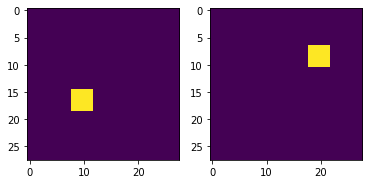

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(square1)
ax2.imshow(square2)

In [12]:
square1 = square1.view(1, 1, 28, 28)
square2 = square2.view(1, 1, 28, 28)

### Activations after convolution

In [13]:
model.zero_grad()
out1 = model.conv1(square1)
out1.mean().backward()
grad1 = copy.deepcopy(model.conv1.weight.grad)

In [14]:
model.zero_grad()
out2 = model.conv1(square2)
out2.mean().backward()
grad2 = copy.deepcopy(model.conv1.weight.grad)

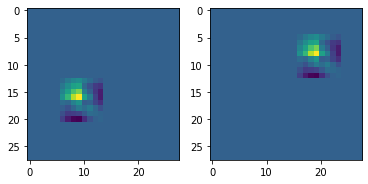

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(out1[0, 0, ...].detach())
ax2.imshow(out2[0, 0, ...].detach())

Note that the outputs are the same, only translated. This exemplifies the so-called *translational equivariance* of the convolution: Translated versions of the input give rise to translated versions of the output.

More generally, equivariance entails that if we vary the input to an operation by applying some transformation, the output varies in an equivalent way. Here, the equivariance is toward translational transformations and the operation is the convolution.

Complete *invariance* is a stronger concept that entails that if we vary the input to an operation by applying some transformation, the output remains the same. It is invariant to that type of transformation to the input.

It turns out, that looking closer at the next layers of our GlobalPoolingCNN model, it is in fact *invariant to translations* in the input.

Looking at the gradients of the convolutional kernel, they are also equal, regardless of which input we give (and which output we backward propagate from, even though they are not identical).

In [16]:
grad1 is grad2, np.allclose(grad1.detach(), grad2.detach())

(False, True)

In [17]:
grad1[0], grad2[0]

(tensor([[[0.0003, 0.0003, 0.0003, 0.0003, 0.0003],
          [0.0003, 0.0003, 0.0003, 0.0003, 0.0003],
          [0.0003, 0.0003, 0.0003, 0.0003, 0.0003],
          [0.0003, 0.0003, 0.0003, 0.0003, 0.0003],
          [0.0003, 0.0003, 0.0003, 0.0003, 0.0003]]]),
 tensor([[[0.0003, 0.0003, 0.0003, 0.0003, 0.0003],
          [0.0003, 0.0003, 0.0003, 0.0003, 0.0003],
          [0.0003, 0.0003, 0.0003, 0.0003, 0.0003],
          [0.0003, 0.0003, 0.0003, 0.0003, 0.0003],
          [0.0003, 0.0003, 0.0003, 0.0003, 0.0003]]]))

### Activations after global max pool

In [18]:
model.zero_grad()
out1 = model.max_pool_layer(square1)
out1.mean().backward()
grad1 = copy.deepcopy(model.conv1.weight.grad)

In [19]:
model.zero_grad()
out2 = model.max_pool_layer(square2)
out2.mean().backward()
grad2 = copy.deepcopy(model.conv1.weight.grad)

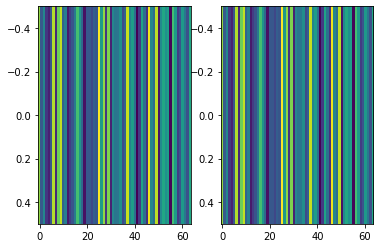

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(out1.detach().view(1, channels), aspect='auto')
ax2.imshow(out2.detach().view(1, channels), aspect='auto')

In [21]:
grad1 is grad2, np.allclose(grad1.detach(), grad2.detach())

(False, True)

In [22]:
grad1[0], grad2[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0156, 0.0156, 0.0156, 0.0156],
          [0.0000, 0.0156, 0.0156, 0.0156, 0.0156],
          [0.0000, 0.0156, 0.0156, 0.0156, 0.0156],
          [0.0000, 0.0156, 0.0156, 0.0156, 0.0156]]]),
 tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0156, 0.0156, 0.0156, 0.0156],
          [0.0000, 0.0156, 0.0156, 0.0156, 0.0156],
          [0.0000, 0.0156, 0.0156, 0.0156, 0.0156],
          [0.0000, 0.0156, 0.0156, 0.0156, 0.0156]]]))

After the global max pooling, our activations are now identical regardless of the input translation. This is *translational invariance*.

### Activations after final softmax classifier

In [23]:
model.zero_grad()
out1 = model(square1)
criterion(out1, torch.LongTensor([0])).backward()
grad1 = copy.deepcopy(model.conv1.weight.grad)

In [24]:
model.zero_grad()
out2 = model(square2)
criterion(out2, torch.LongTensor([0])).backward()
grad2 = copy.deepcopy(model.conv1.weight.grad)

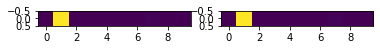

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(out1.detach().view(1, 10))
ax2.imshow(out2.detach().view(1, 10))

In [26]:
out1 is out2, np.allclose(out1.detach(), out2.detach())

(False, True)

In [27]:
grad1 is grad2, np.allclose(grad1.detach(), grad2.detach())

(False, True)

In [28]:
grad1[0], grad2[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0003, 0.0003, 0.0003, 0.0003],
          [0.0000, 0.0003, 0.0003, 0.0003, 0.0003],
          [0.0000, 0.0003, 0.0003, 0.0003, 0.0003],
          [0.0000, 0.0003, 0.0003, 0.0003, 0.0003]]]),
 tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0003, 0.0003, 0.0003, 0.0003],
          [0.0000, 0.0003, 0.0003, 0.0003, 0.0003],
          [0.0000, 0.0003, 0.0003, 0.0003, 0.0003],
          [0.0000, 0.0003, 0.0003, 0.0003, 0.0003]]]))

### Conclusion

The first convolutional layer is translationally invariant by the design of the convolution operation.

The global max pooling layer effectively removes all spatial information from the spatial feature map output from the convolution.

The resulting $B \times C$ vector (batch matrix) is fed to the final linear classifier which, since there is no spatial information, is also invariant to translations, by design.

We conclude this based on the fact that the gradient of the convolutional kernel computed from the mean of the output at each of these steps is equal for both the original and the translated inputs.

Since the gradient is identical, the kernel would have been updated identically using either input image. This also shows that translations are not an effective data augmentation technique for CNNs if design such that the final linear layer does not act on a spatial feature map.

# Convolutional model with local pooling

## Train
To get some non-random kernels, we start by training the model for a bit. This will allow the kernels to become useful. This is not strictly necessary, but brings the example closer to reality.

In [29]:
# Define model, optimizer and loss
model = LocalPoolCNN()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

In [30]:
model.to(device)
criterion.to(device)

CrossEntropyLoss()

In [31]:
# Training loop
n_epochs = 10

for epoch in range(n_epochs):
    train_loss = []
    test_loss = []
    for x, y in tqdm(train_loader):
        optimizer.zero_grad()

        x = x.to(device)
        y = y.to(device)

        yhat = model(x)  # Forward pass
        loss = criterion(yhat, y)  # Compute loss

        loss.backward()  # Backward pass
        optimizer.step()  # Update parameters

        train_loss.append(loss.item())

    print(f'Epoch {epoch:3d} | Train loss {np.mean(train_loss):.2f}', end='')

    for x, y in test_loader:
        optimizer.zero_grad()

        x = x.to(device)
        y = y.to(device)

        yhat = model(x)
        loss = criterion(yhat, y)

        test_loss.append(loss.item())

    print(f' | Test loss {np.mean(test_loss):.2f}', end='\n')

100%|██████████| 1875/1875 [00:10<00:00, 173.08it/s]

Epoch   0 | Train loss 1.55


  0%|          | 0/1875 [00:00<?, ?it/s]

 | Test loss 1.49


100%|██████████| 1875/1875 [00:10<00:00, 179.58it/s]

Epoch   1 | Train loss 1.49


  0%|          | 0/1875 [00:00<?, ?it/s]

 | Test loss 1.48


100%|██████████| 1875/1875 [00:10<00:00, 175.80it/s]

Epoch   2 | Train loss 1.48


  0%|          | 0/1875 [00:00<?, ?it/s]

 | Test loss 1.48


100%|██████████| 1875/1875 [00:10<00:00, 171.75it/s]

Epoch   3 | Train loss 1.48


  0%|          | 0/1875 [00:00<?, ?it/s]

 | Test loss 1.48


100%|██████████| 1875/1875 [00:11<00:00, 163.66it/s]

Epoch   4 | Train loss 1.48


  0%|          | 0/1875 [00:00<?, ?it/s]

 | Test loss 1.47


100%|██████████| 1875/1875 [00:12<00:00, 155.78it/s]

Epoch   5 | Train loss 1.47


  0%|          | 0/1875 [00:00<?, ?it/s]

 | Test loss 1.48


100%|██████████| 1875/1875 [00:12<00:00, 151.70it/s]

Epoch   6 | Train loss 1.47


  0%|          | 0/1875 [00:00<?, ?it/s]

 | Test loss 1.48


100%|██████████| 1875/1875 [00:11<00:00, 166.27it/s]

Epoch   7 | Train loss 1.47


  0%|          | 0/1875 [00:00<?, ?it/s]

 | Test loss 1.47


100%|██████████| 1875/1875 [00:10<00:00, 174.98it/s]

Epoch   8 | Train loss 1.47


  0%|          | 0/1875 [00:00<?, ?it/s]

 | Test loss 1.48


100%|██████████| 1875/1875 [00:11<00:00, 168.07it/s]

Epoch   9 | Train loss 1.47

 | Test loss 1.47


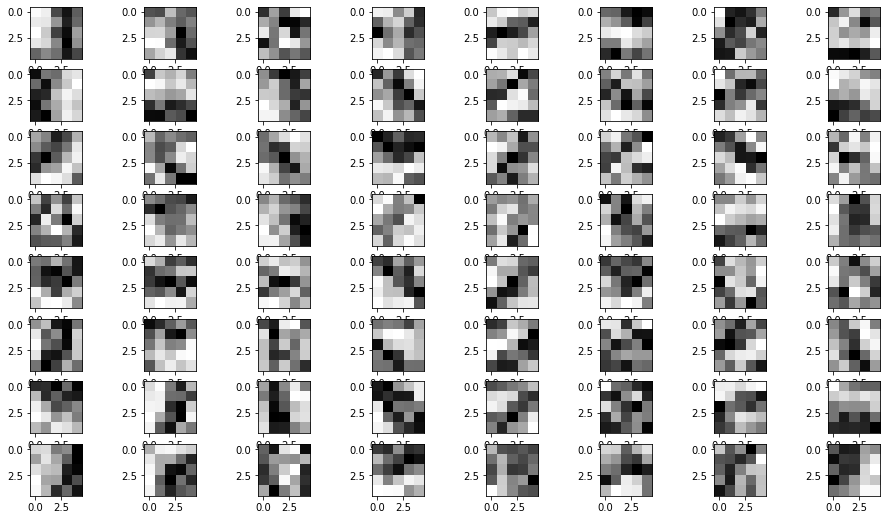

In [32]:
height = int(np.ceil(np.sqrt(channels)))
width = int(np.ceil(np.sqrt(channels)))

fig, axes = plt.subplots(height, width, figsize=(16, 9))
axes = [ax for a in axes for ax in a]

kernels = copy.deepcopy(model.conv1.weight)
kernels = kernels.cpu().detach()
for i, kernel in enumerate(kernels):
    axes[i].imshow(kernel.view(kernel_size, kernel_size), cmap='Greys')

## Check invariance

In [33]:
model.cpu()

LocalPoolCNN(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool): MaxPool2d(kernel_size=5, stride=2, padding=2, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=12544, out_features=10, bias=True)
  (relu1): ReLU()
  (relu2): ReLU()
  (softmax): Softmax(dim=-1)
)

In [34]:
square1 = torch.zeros(28, 28)
square1[15:19, 8:12] = 1

square2 = torch.zeros(28, 28)
square2[7:11, 18:22] = 1

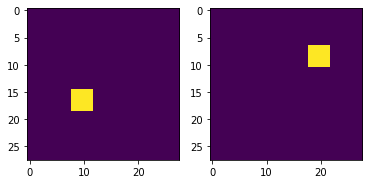

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(square1)
ax2.imshow(square2)

In [36]:
square1 = square1.view(1, 1, 28, 28)
square2 = square2.view(1, 1, 28, 28)

### Activations after convolution

In [37]:
model.zero_grad()
out1 = model.conv1(square1)
out1.mean().backward()
grad1 = copy.deepcopy(model.conv1.weight.grad)

In [38]:
model.zero_grad()
out2 = model.conv1(square2)
out2.mean().backward()
grad2 = copy.deepcopy(model.conv1.weight.grad)

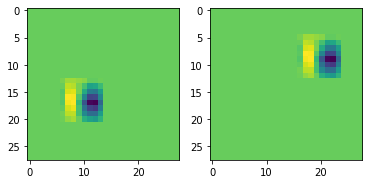

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(out1[0, 0, ...].detach())
ax2.imshow(out2[0, 0, ...].detach())

In [40]:
grad1 is grad2, np.allclose(grad1.detach(), grad2.detach())

(False, True)

In [41]:
grad1[0], grad2[0]

(tensor([[[0.0003, 0.0003, 0.0003, 0.0003, 0.0003],
          [0.0003, 0.0003, 0.0003, 0.0003, 0.0003],
          [0.0003, 0.0003, 0.0003, 0.0003, 0.0003],
          [0.0003, 0.0003, 0.0003, 0.0003, 0.0003],
          [0.0003, 0.0003, 0.0003, 0.0003, 0.0003]]]),
 tensor([[[0.0003, 0.0003, 0.0003, 0.0003, 0.0003],
          [0.0003, 0.0003, 0.0003, 0.0003, 0.0003],
          [0.0003, 0.0003, 0.0003, 0.0003, 0.0003],
          [0.0003, 0.0003, 0.0003, 0.0003, 0.0003],
          [0.0003, 0.0003, 0.0003, 0.0003, 0.0003]]]))

### Activations after local max pool

In [42]:
model.zero_grad()
out1 = model.max_pool_layer(square1)
out1.mean().backward()
grad1 = copy.deepcopy(model.conv1.weight.grad)

In [43]:
model.zero_grad()
out2 = model.max_pool_layer(square2)
out2.mean().backward()
grad2 = copy.deepcopy(model.conv1.weight.grad)

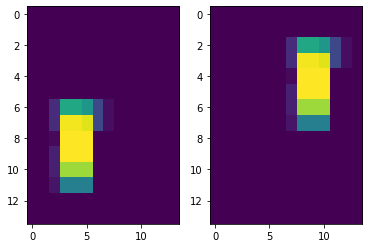

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(out1.detach()[0, 0, ...], aspect='auto')
ax2.imshow(out2.detach()[0, 0, ...], aspect='auto')

In [45]:
grad1 is grad2, np.allclose(grad1.detach(), grad2.detach())

(False, True)

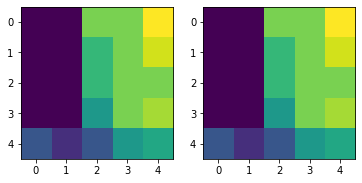

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(grad1.detach()[0,0])
ax2.imshow(grad2.detach()[0,0])

In [47]:
grad1[0], grad2[0]

(tensor([[[0.0000, 0.0000, 0.0010, 0.0010, 0.0012],
          [0.0000, 0.0000, 0.0008, 0.0010, 0.0011],
          [0.0000, 0.0000, 0.0008, 0.0010, 0.0010],
          [0.0000, 0.0000, 0.0006, 0.0010, 0.0010],
          [0.0003, 0.0002, 0.0003, 0.0006, 0.0007]]]),
 tensor([[[0.0000, 0.0000, 0.0010, 0.0010, 0.0012],
          [0.0000, 0.0000, 0.0008, 0.0010, 0.0011],
          [0.0000, 0.0000, 0.0008, 0.0010, 0.0010],
          [0.0000, 0.0000, 0.0006, 0.0010, 0.0010],
          [0.0003, 0.0002, 0.0003, 0.0006, 0.0007]]]))

### Activations after final softmax classifier

In [48]:
model.zero_grad()
out1 = model(square1)
criterion(out1, torch.LongTensor([0])).backward()
grad1 = copy.deepcopy(model.conv1.weight.grad)

In [49]:
model.zero_grad()
out2 = model(square2)
criterion(out2, torch.LongTensor([0])).backward()
grad2 = copy.deepcopy(model.conv1.weight.grad)

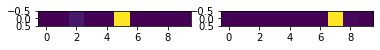

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(out1.detach().view(1, 10))
ax2.imshow(out2.detach().view(1, 10))

In [51]:
out1 is out2, np.allclose(out1.detach(), out2.detach())

(False, False)

In [52]:
grad1 is grad2, np.allclose(grad1.detach(), grad2.detach())

(False, False)

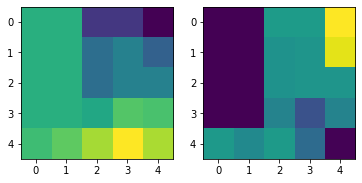

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(grad1.detach()[0,0])
ax2.imshow(grad2.detach()[0,0])

In [54]:
grad1[0], grad2[0]

(tensor([[[ 0.0000,  0.0000, -0.0042, -0.0042, -0.0056],
          [ 0.0000,  0.0000, -0.0024, -0.0017, -0.0029],
          [ 0.0000,  0.0000, -0.0024, -0.0017, -0.0017],
          [ 0.0000,  0.0000, -0.0003,  0.0009,  0.0007],
          [ 0.0005,  0.0011,  0.0021,  0.0033,  0.0021]]]),
 tensor([[[0.0000e+00, 0.0000e+00, 1.6463e-03, 1.6463e-03, 2.9976e-03],
          [0.0000e+00, 0.0000e+00, 1.5339e-03, 1.5639e-03, 2.8767e-03],
          [0.0000e+00, 0.0000e+00, 1.5339e-03, 1.5639e-03, 1.5639e-03],
          [0.0000e+00, 0.0000e+00, 1.3427e-03, 7.5951e-04, 1.3370e-03],
          [1.6246e-03, 1.4205e-03, 1.6307e-03, 1.0475e-03, 1.5777e-05]]]))

### Conclusion 
The local pooling CNN preservers has a (flattened) spatial map as input to the final linear classifciation layer.

Since the linear layer is fully connected, it is sensitive to the location of high and low activations in its input.

For this reason, the final layer is *not invariant to translations* in the input by design - this will have to be learned.

# MLP Classifier

## Train

In [55]:
# Define model, optimizer and loss
model = MLP()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

In [56]:
model.to(device)
criterion.to(device)

CrossEntropyLoss()

In [57]:
# Training loop
n_epochs = 10

for epoch in range(n_epochs):
    train_loss = []
    test_loss = []
    for x, y in tqdm(train_loader):
        optimizer.zero_grad()

        x = x.to(device)
        y = y.to(device)

        yhat = model(x)  # Forward pass
        loss = criterion(yhat, y)  # Compute loss

        loss.backward()  # Backward pass
        optimizer.step()  # Update parameters

        train_loss.append(loss.item())

    print(f'Epoch {epoch:3d} | Train loss {np.mean(train_loss):.2f}', end='')

    for x, y in test_loader:
        optimizer.zero_grad()

        x = x.to(device)
        y = y.to(device)

        yhat = model(x)
        loss = criterion(yhat, y)

        test_loss.append(loss.item())

    print(f' | Test loss {np.mean(test_loss):.2f}', end='\n')

100%|██████████| 1875/1875 [00:11<00:00, 166.04it/s]

Epoch   0 | Train loss 1.68


  0%|          | 0/1875 [00:00<?, ?it/s]

 | Test loss 1.56


100%|██████████| 1875/1875 [00:11<00:00, 170.37it/s]

Epoch   1 | Train loss 1.56


  0%|          | 0/1875 [00:00<?, ?it/s]

 | Test loss 1.54


100%|██████████| 1875/1875 [00:11<00:00, 168.04it/s]

Epoch   2 | Train loss 1.54


  0%|          | 0/1875 [00:00<?, ?it/s]

 | Test loss 1.53


100%|██████████| 1875/1875 [00:11<00:00, 164.56it/s]

Epoch   3 | Train loss 1.53


  0%|          | 0/1875 [00:00<?, ?it/s]

 | Test loss 1.53


100%|██████████| 1875/1875 [00:11<00:00, 156.94it/s]

Epoch   4 | Train loss 1.52


  0%|          | 0/1875 [00:00<?, ?it/s]

 | Test loss 1.52


100%|██████████| 1875/1875 [00:12<00:00, 154.24it/s]

Epoch   5 | Train loss 1.52


  0%|          | 0/1875 [00:00<?, ?it/s]

 | Test loss 1.52


100%|██████████| 1875/1875 [00:11<00:00, 169.55it/s]

Epoch   6 | Train loss 1.51


  0%|          | 0/1875 [00:00<?, ?it/s]

 | Test loss 1.52


100%|██████████| 1875/1875 [00:11<00:00, 165.05it/s]

Epoch   7 | Train loss 1.51


  0%|          | 0/1875 [00:00<?, ?it/s]

 | Test loss 1.51


100%|██████████| 1875/1875 [00:11<00:00, 164.68it/s]

Epoch   8 | Train loss 1.51


  0%|          | 0/1875 [00:00<?, ?it/s]

 | Test loss 1.51


100%|██████████| 1875/1875 [00:10<00:00, 171.14it/s]

Epoch   9 | Train loss 1.50

 | Test loss 1.51


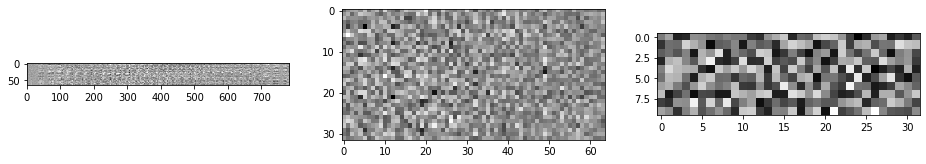

In [58]:
fig, axes = plt.subplots(1, 3, figsize=(16, 9))

weights = [copy.deepcopy(weight).detach().cpu() for weight in model.parameters() if weight.ndim == 2]
for i, weight in enumerate(weights):
    axes[i].imshow(weight, cmap='Greys')

## Check invariance

In [59]:
model.cpu()

MLP(
  (linear_1): Linear(in_features=784, out_features=64, bias=True)
  (linear_2): Linear(in_features=64, out_features=32, bias=True)
  (linear_3): Linear(in_features=32, out_features=10, bias=True)
  (relu1): ReLU()
  (relu2): ReLU()
  (softmax): Softmax(dim=-1)
)

In [60]:
square1 = torch.zeros(28, 28)
square1[15:19, 8:12] = 1

square2 = torch.zeros(28, 28)
square2[7:11, 18:22] = 1

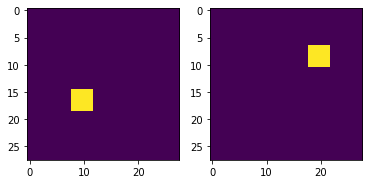

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(square1)
ax2.imshow(square2)

In [62]:
square1 = square1.view(1, 1, 28, 28)
square2 = square2.view(1, 1, 28, 28)

### Activations after first layer

In [63]:
model.zero_grad()
out1 = model.layer1(square1)
out1.mean().backward()
grad1 = copy.deepcopy(model.linear_1.weight.grad)

In [64]:
model.zero_grad()
out2 = model.layer1(square2)
out2.mean().backward()
grad2 = copy.deepcopy(model.linear_1.weight.grad)

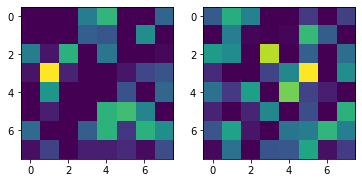

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(out1.detach().view(8, 8))
ax2.imshow(out2.detach().view(8, 8))

In [66]:
out1 is out2, np.allclose(out1.detach(), out2.detach())

(False, False)

In [67]:
grad1 is grad2, np.allclose(grad1.detach(), grad2.detach())

(False, False)

For this fully connected classifier, there is no equivariance by design at the first layer. Hence, there is also no invariance.

Any resemblence between the outputs is due to learned equivariance/invariance.

Since the first layer is not equivariant (or invariant), the following also can't be. They can however learn it.

### Activations after second layer

In [68]:
model.zero_grad()
out1 = model.layer2(square1)
out1.mean().backward()
grad1 = copy.deepcopy(model.linear_1.weight.grad)

In [69]:
model.zero_grad()
out2 = model.layer2(square2)
out2.mean().backward()
grad2 = copy.deepcopy(model.linear_1.weight.grad)

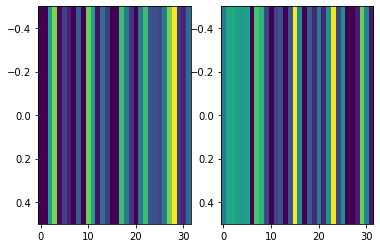

In [70]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(out1.detach().view(1, 32), aspect='auto')
ax2.imshow(out2.detach().view(1, 32), aspect='auto')

In [71]:
out1 is out2, np.allclose(out1.detach(), out2.detach())

(False, False)

In [72]:
grad1 is grad2, np.allclose(grad1.detach(), grad2.detach())

(False, False)

### Activations after final softmax classifier

In [73]:
model.zero_grad()
out1 = model(square1)
criterion(out1, torch.LongTensor([0])).backward()
grad1 = copy.deepcopy(model.linear_1.weight.grad)

In [74]:
model.zero_grad()
out2 = model(square2)
criterion(out2, torch.LongTensor([0])).backward()
grad2 = copy.deepcopy(model.linear_1.weight.grad)

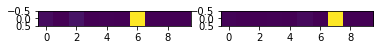

In [75]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(out1.detach().view(1, 10))
ax2.imshow(out2.detach().view(1, 10))

In [76]:
out1, out2

(tensor([[3.0773e-02, 8.1441e-05, 4.7908e-02, 1.3386e-06, 3.8451e-03, 6.7996e-05,
          9.1697e-01, 1.2310e-04, 1.2872e-04, 1.0529e-04]],
        grad_fn=<SoftmaxBackward>),
 tensor([[9.8737e-03, 4.1096e-06, 2.4713e-03, 4.5151e-03, 6.1128e-07, 2.5778e-02,
          7.2495e-08, 9.5603e-01, 1.3736e-04, 1.1936e-03]],
        grad_fn=<SoftmaxBackward>))

In [77]:
out1 is out2, np.allclose(out1.detach(), out2.detach())

(False, False)

In [78]:
grad1 is grad2, np.allclose(grad1.detach(), grad2.detach())

(False, False)